# Data Science Library demo
Here I demonstrate the data science library I developed to quickly build scikit learn pipelines with optional scaling, feature interaction, data transformation (e.g. PCA, t-SNE) steps. It runs the pipeline through a grid-search (all combinations or a specific number of them) stratified (if classification) k-folds cross-validation and outputs the best model.

## Titanic dataset
Here I use the Titanic dataset I've cleaned and pickled in a separate tutorial.

### Import data

In [1]:
import pandas as pd

df = pd.read_pickle('trimmed_titanic_data.pkl')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 890 entries, 0 to 890
Data columns (total 9 columns):
Survived    890 non-null int64
Pclass      890 non-null int64
Sex         890 non-null object
Age         890 non-null float64
SibSp       890 non-null int64
Parch       890 non-null int64
Fare        890 non-null float64
Embarked    890 non-null object
Title       890 non-null object
dtypes: float64(2), int64(4), object(3)
memory usage: 69.5+ KB


By "cleaned" I mean I've derived titles (e.g. "Mr.", "Mrs.", "Dr.", etc) from the passenger names, imputed the missing Age values using polynomial regression with grid-searched 10-fold cross-validation, filled in the 3 missing Embarked values with the mode, and removed all fields that could be considered an id for that individual.

Thus, there is no missing data.

## Set categorical features as type 'category'

In [2]:
simulation_df = df.copy()

categorical_features = ['Survived','Pclass','Sex','Embarked','Title']

for feature in categorical_features:
    simulation_df[feature] = simulation_df[feature].astype('category')
    
simulation_df.info()

# df["A"].astype('category')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 890 entries, 0 to 890
Data columns (total 9 columns):
Survived    890 non-null category
Pclass      890 non-null category
Sex         890 non-null category
Age         890 non-null float64
SibSp       890 non-null int64
Parch       890 non-null int64
Fare        890 non-null float64
Embarked    890 non-null category
Title       890 non-null category
dtypes: category(5), float64(2), int64(2)
memory usage: 39.3 KB


## One-hot encode categorical features

In [3]:
simulation_df = pd.get_dummies(simulation_df,drop_first=True)

simulation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 890 entries, 0 to 890
Data columns (total 17 columns):
Age               890 non-null float64
SibSp             890 non-null int64
Parch             890 non-null int64
Fare              890 non-null float64
Survived_1        890 non-null uint8
Pclass_2          890 non-null uint8
Pclass_3          890 non-null uint8
Sex_male          890 non-null uint8
Embarked_Q        890 non-null uint8
Embarked_S        890 non-null uint8
Title_Dr          890 non-null uint8
Title_Military    890 non-null uint8
Title_Miss        890 non-null uint8
Title_Mr          890 non-null uint8
Title_Mrs         890 non-null uint8
Title_Noble       890 non-null uint8
Title_Rev         890 non-null uint8
dtypes: float64(2), int64(2), uint8(13)
memory usage: 46.1 KB


Now we have 17 features.

### Split into input/output data

In [4]:
# Set output feature
output_feature = 'Survived_1'

# Get all column names
column_names = list(simulation_df.columns)

# Exclude one of every categorical variable since the other one-hot encodings cover everything
input_features = [x for x in column_names if x != output_feature]

# Split into features and responses
X = simulation_df[input_features].copy()
y = simulation_df[output_feature].copy()

### Null model

In [5]:
simulation_df['Survived_1'].value_counts().values/float(simulation_df['Survived_1'].value_counts().values.sum())

array([ 0.61573034,  0.38426966])

Thus, null accuracy of ~62% if always predict death.

### Import data science library and initialize optimized pipeline collection

In [401]:
import data_science_lib as dsl

optimized_pipelines = {}

### Basic models w/ no pre-processing
#### KNN
Here I do a simple K-nearest neighbors (KNN) classification with straitified 10-fold (default) cross-validation with a grid search over the default of 1 to 30 nearest neighbors and the use of either "uniform" or "distance" weights:

In [402]:
%%time

reload(dsl)

estimator = 'knn'

# Set pipeline keyword arguments
optimized_pipeline_kwargs = {
    'feature_selection_type': None,
    'scale_type': None,
    'feature_interactions': False,
    'transform_type': None
    }

# Initialize pipeline
optimized_pipeline = dsl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)

# Set pipeline fitting parameters
fit_kwargs = {
    'cv': 10,
    'num_parameter_combos': None,
    'n_jobs': -1,
    'random_state': 6,
    'suppress_output': True,
    'use_default_param_dist': True,
    'param_dist': None,
    'test_size': 0.2 # 20% saved as test set
}

# Fit data
optimized_pipeline.fit(X,y,**fit_kwargs)

# Save 
optimized_pipelines[estimator] = optimized_pipeline

CPU times: user 1.8 s, sys: 274 ms, total: 2.08 s
Wall time: 2.98 s


The output of the train_model() method is an instance of my custom OptimizedPipeline class  containing all of the data associated with the nested stratified k-folds cross-validation.

This includes the data, its test/train splits (based on the test_size percentage keyword argument), the GridSearchCV or RandomizedGridSearchCV object, the Pipeline object that has been retrained using all of the data with the best parameters, test/train scores, and validation metrics/reports.

A report summarizing many of these properties results from printing the OptimizedPipeline class instance:

In [400]:
print optimized_pipeline


Pipeline:

1: estimator   KNeighborsClassifier           
                                              
               n_neighbors          = 12        
               n_jobs               = 1         
               algorithm            = auto      
               metric               = minkowski 
               metric_params        = None      
               p                    = 2         
               weights              = uniform   
               leaf_size            = 30        
                                              

Training set classification accuracy:	0.729
Test set classification accuracy:	0.736

Confusion matrix:

[[99  7]
 [40 32]]

Normalized confusion matrix:

[[ 0.55617978  0.03932584]
 [ 0.2247191   0.17977528]]

Classification report:

             precision    recall  f1-score   support

          0       0.71      0.93      0.81       106
          1       0.82      0.44      0.58        72

avg / total       0.76      0.74      0.71       178


Grid

It lists the steps in the pipeline, their optimized settings, the test/training accuracy (or L2 regression score), the grid search parameters, and the best parameters.

If the estimator used is a classifier it also includes the confusion matrix, normalized confusion matrix, and a classification report containing precision/recall/f1-score for each class.

The report can also be printed immediately after the fit by setting the suppress_output keyword argument to True.

Turns out that the best settings are 12 neighbors and the use of the 'uniform' weight.

Note how I've set the random_state keyword agument to 6 so that the models can be compared using the same test/train split.

The default parameters to grid-search over for k-nearest neighbors is 1 to 30 neighbors and either the 'uniform' or 'distance' weight.

This can be changed in two different ways. One way is to overwrite the parameter values by setting the param_dist keyword argument with the use_default_param_dist set to True:

In [403]:
%%time

reload(dsl)

model_name = 'custom_overwrite_%s'%(estimator_name)

# Set custom parameters
param_dist = {
    'estimator__n_neighbors': range(30,500)
}

estimator = 'knn'

# Set pipeline keyword arguments
optimized_pipeline_kwargs = {
    'feature_selection_type': None,
    'scale_type': None,
    'feature_interactions': False,
    'transform_type': None
    }

# Initialize pipeline
optimized_pipeline = dsl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)

# Set pipeline fitting parameters
fit_kwargs = {
    'cv': 10,
    'num_parameter_combos': None,
    'n_jobs': -1,
    'random_state': 6,
    'suppress_output': False,
    'use_default_param_dist': True,
    'param_dist': param_dist,
    'test_size': 0.2 # 20% saved as test set
}

# Fit data
optimized_pipeline.fit(X,y,**fit_kwargs)

# Save 
optimized_pipelines[model_name] = optimized_pipeline


Pipeline:

1: estimator   KNeighborsClassifier           
                                              
               n_neighbors          = 50        
               n_jobs               = 1         
               algorithm            = auto      
               metric               = minkowski 
               metric_params        = None      
               p                    = 2         
               weights              = distance  
               leaf_size            = 30        
                                              

Training set classification accuracy:	0.739
Test set classification accuracy:	0.719

Confusion matrix:

[[95 11]
 [39 33]]

Normalized confusion matrix:

[[ 0.53370787  0.06179775]
 [ 0.21910112  0.18539326]]

Classification report:

             precision    recall  f1-score   support

          0       0.71      0.90      0.79       106
          1       0.75      0.46      0.57        72

avg / total       0.73      0.72      0.70       178


Grid

The second way to use different parameter grid values is to set them with the custom param_dist keyword argument yet set use_default_param_dist to False. This makes it so that you must set every single parameter manually:

In [404]:
%%time

reload(dsl)

model_name = 'from_scratch_%s'%(estimator_name)

# Set custom parameters
param_dist = {
    'estimator__n_neighbors': range(10,30)
}

estimator = 'knn'

# Set pipeline keyword arguments
optimized_pipeline_kwargs = {
    'feature_selection_type': None,
    'scale_type': None,
    'feature_interactions': False,
    'transform_type': None
    }

# Initialize pipeline
optimized_pipeline = dsl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)

# Set pipeline fitting parameters
fit_kwargs = {
    'cv': 10,
    'num_parameter_combos': None,
    'n_jobs': -1,
    'random_state': 6,
    'suppress_output': False,
    'use_default_param_dist': False,
    'param_dist': param_dist,
    'test_size': 0.2 # 20% saved as test set
}

# Fit data
optimized_pipeline.fit(X,y,**fit_kwargs)

# Save 
optimized_pipelines[model_name] = optimized_pipeline


Pipeline:

1: estimator   KNeighborsClassifier           
                                              
               n_neighbors          = 12        
               n_jobs               = 1         
               algorithm            = auto      
               metric               = minkowski 
               metric_params        = None      
               p                    = 2         
               weights              = uniform   
               leaf_size            = 30        
                                              

Training set classification accuracy:	0.729
Test set classification accuracy:	0.736

Confusion matrix:

[[99  7]
 [40 32]]

Normalized confusion matrix:

[[ 0.55617978  0.03932584]
 [ 0.2247191   0.17977528]]

Classification report:

             precision    recall  f1-score   support

          0       0.71      0.93      0.81       106
          1       0.82      0.44      0.58        72

avg / total       0.76      0.74      0.71       178


Grid

Note how the estimator\_\_weights parameter isn't set for the KNN estimator.

#### Other models

This code currently supports K-nearest neighbors, logistic regression, support vector machines, multilayer perceptrons, random forest, and adaboost.
We can loop through and pick the best model like this:

In [416]:
%%time

reload(dsl)

classifiers = ['knn','logistic_regression','svm','multilayer_perceptron','random_forest','adaboost']

for estimator in classifiers:
    # Set pipeline keyword arguments
    optimized_pipeline_kwargs = {
        'feature_selection_type': None,
        'scale_type': None,
        'feature_interactions': False,
        'transform_type': None
        }

    # Initialize pipeline
    optimized_pipeline = dsl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)
    
    # Set pipeline fitting parameters
    fit_kwargs = {
        'cv': 10,
        'num_parameter_combos': None,
        'n_jobs': -1,
        'random_state': 6,
        'suppress_output': True,
        'use_default_param_dist': True,
        'param_dist': None,
        'test_size': 0.2
    }
    
    # Fit data
    optimized_pipeline.fit(X,y,**fit_kwargs)
    
    # Save 
    optimized_pipelines[estimator] = optimized_pipeline

CPU times: user 5.65 s, sys: 516 ms, total: 6.16 s
Wall time: 41.3 s


In [417]:
format_str = '{0:<22} {1:<15} {2:<15}'

print format_str.format(*['model','train score','test score'])
print format_str.format(*['','',''])
for x in [[key,value.train_score_,value.test_score_] for key,value in optimized_pipelines.iteritems()]:
    print format_str.format(*x)

model                  train score     test score     
                                                      
knn                    0.72893258427   0.73595505618  
svm                    0.72893258427   0.752808988764 
logistic_regression    0.828651685393  0.842696629213 
adaboost               0.794943820225  0.837078651685 
random_forest          0.818820224719  0.85393258427  
multilayer_perceptron  0.821629213483  0.803370786517 


Random forest performed the best with a test score of ~0.854.

Lets look at the report:

In [422]:
print optimized_pipelines['random_forest']


Pipeline:

1: estimator   RandomForestClassifier           
                                              
               warm_start           = 0         
               oob_score            = 0         
               n_jobs               = 1         
               verbose              = 0         
               max_leaf_nodes       = None      
               bootstrap            = 1         
               min_samples_leaf     = 1         
               n_estimators         = 96        
               min_samples_split    = 2         
               min_weight_fraction_leaf = 0.0       
               criterion            = gini      
               random_state         = None      
               min_impurity_split   = 1e-07     
               max_features         = auto      
               max_depth            = None      
               class_weight         = None      
                                              

Training set classification accuracy:	0.819
Test set cla

This, by itself, isn't really that impressive. The power my data_science_lib tool becomes more obvious once we start extending the pipeline.

### All models with standard scaling
We can set the scaling type using the scale_type keyword argument:

In [419]:
%%time

reload(dsl)

classifiers = ['knn','logistic_regression','svm','multilayer_perceptron','random_forest','adaboost']

prefix = 'scale'

for estimator in classifiers:
    # Set pipeline keyword arguments
    optimized_pipeline_kwargs = {
        'feature_selection_type': None,
        'scale_type': 'standard',
        'feature_interactions': False,
        'transform_type': None
        }

    # Initialize pipeline
    optimized_pipeline = dsl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)
    
    # Set pipeline fitting parameters
    fit_kwargs = {
        'cv': 10,
        'num_parameter_combos': None,
        'n_jobs': -1,
        'random_state': 6,
        'suppress_output': True,
        'use_default_param_dist': True,
        'param_dist': None,
        'test_size': 0.2
    }
    
    # Fit data
    optimized_pipeline.fit(X,y,**fit_kwargs)
    
    # Form name used to save optimized pipeline
    pipeline_name = '%s_%s'%(prefix,estimator)
    
    # Save 
    optimized_pipelines[pipeline_name] = optimized_pipeline

CPU times: user 6.83 s, sys: 687 ms, total: 7.52 s
Wall time: 43 s


In [421]:
format_str = '{0:<30} {1:<15} {2:<15}'

print format_str.format(*['model','train score','test score'])
print format_str.format(*['','',''])
for x in [[key,value.train_score_,value.test_score_] for key,value in optimized_pipelines.iteritems()]:
    print format_str.format(*x)

model                          train score     test score     
                                                              
knn                            0.72893258427   0.73595505618  
svm                            0.72893258427   0.752808988764 
scale_logistic_regression      0.828651685393  0.842696629213 
scale_adaboost                 0.794943820225  0.837078651685 
scale_multilayer_perceptron    0.830056179775  0.814606741573 
logistic_regression            0.828651685393  0.842696629213 
scale_random_forest            0.825842696629  0.837078651685 
adaboost                       0.794943820225  0.837078651685 
random_forest                  0.818820224719  0.85393258427  
scale_knn                      0.825842696629  0.808988764045 
multilayer_perceptron          0.821629213483  0.803370786517 
scale_svm                      0.832865168539  0.814606741573 


Random forest without scaling still appears to have the best test score. Though that with scaling had closer test and train scores.

### All models with SelectKBest feature selection
Setting the feature_selection_type keyword argument will use SelectKBest with f_classif for feature selection: 

In [423]:
%%time

reload(dsl)

classifiers = ['knn','logistic_regression','svm','multilayer_perceptron','random_forest','adaboost']

prefix = 'select'

for estimator in classifiers:
    # Set pipeline keyword arguments
    optimized_pipeline_kwargs = {
        'feature_selection_type': 'select_k_best',
        'scale_type': None,
        'feature_interactions': False,
        'transform_type': None
        }

    # Initialize pipeline
    optimized_pipeline = dsl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)
    
    # Set pipeline fitting parameters
    fit_kwargs = {
        'cv': 10,
        'num_parameter_combos': None,
        'n_jobs': -1,
        'random_state': 6,
        'suppress_output': True,
        'use_default_param_dist': True,
        'param_dist': None,
        'test_size': 0.2
    }
    
    # Fit data
    optimized_pipeline.fit(X,y,**fit_kwargs)
    
    # Form name used to save optimized pipeline
    pipeline_name = '%s_%s'%(prefix,estimator)
    
    # Save 
    optimized_pipelines[pipeline_name] = optimized_pipeline

CPU times: user 1min 14s, sys: 4.46 s, total: 1min 18s
Wall time: 10min 54s


In [425]:
format_str = '{0:<30} {1:<15} {2:<15} {3:<15}'

print format_str.format(*['model','train score','test score','train-test'])
print format_str.format(*['','','',''])
for x in [[key,value.train_score_,value.test_score_,value.train_score_-value.test_score_] for key,value in optimized_pipelines.iteritems()]:
    print format_str.format(*x)

model                          train score     test score      train-test     
                                                                              
knn                            0.72893258427   0.73595505618   -0.00702247191011
select_random_forest           0.816011235955  0.820224719101  -0.00421348314607
svm                            0.72893258427   0.752808988764  -0.0238764044944
scale_logistic_regression      0.828651685393  0.842696629213  -0.0140449438202
select_adaboost                0.800561797753  0.831460674157  -0.0308988764045
select_logistic_regression     0.831460674157  0.848314606742  -0.0168539325843
select_knn                     0.789325842697  0.758426966292  0.0308988764045
select_multilayer_perceptron   0.828651685393  0.792134831461  0.0365168539326
scale_adaboost                 0.794943820225  0.837078651685  -0.0421348314607
scale_multilayer_perceptron    0.830056179775  0.814606741573  0.0154494382022
logistic_regression            0.8286516853

Again, random_forest performs the best. 

Though K-nearest neighbors appears to have the smallest difference between testing and training sets.

In [426]:
%%time

reload(dsl)

classifiers = ['knn','logistic_regression','svm','multilayer_perceptron','random_forest','adaboost']

prefix = 'interact'

for estimator in classifiers:
    # Set pipeline keyword arguments
    optimized_pipeline_kwargs = {
        'feature_selection_type': None,
        'scale_type': None,
        'feature_interactions': True,
        'transform_type': None
        }

    # Initialize pipeline
    optimized_pipeline = dsl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)
    
    # Set pipeline fitting parameters
    fit_kwargs = {
        'cv': 10,
        'num_parameter_combos': None,
        'n_jobs': -1,
        'random_state': 6,
        'suppress_output': True,
        'use_default_param_dist': True,
        'param_dist': None,
        'test_size': 0.2
    }
    
    # Fit data
    optimized_pipeline.fit(X,y,**fit_kwargs)
    
    # Form name used to save optimized pipeline
    pipeline_name = '%s_%s'%(prefix,estimator)
    
    # Save 
    optimized_pipelines[pipeline_name] = optimized_pipeline

/Users/cmshymansky/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


CPU times: user 12.3 s, sys: 994 ms, total: 13.3 s
Wall time: 1min 42s


In [427]:
format_str = '{0:<30} {1:<15} {2:<15} {3:<15}'

print format_str.format(*['model','train score','test score','train-test'])
print format_str.format(*['','','',''])
for x in [[key,value.train_score_,value.test_score_,value.train_score_-value.test_score_] for key,value in optimized_pipelines.iteritems()]:
    print format_str.format(*x)

model                          train score     test score      train-test     
                                                                              
scale_logistic_regression      0.828651685393  0.842696629213  -0.0140449438202
select_knn                     0.789325842697  0.758426966292  0.0308988764045
scale_multilayer_perceptron    0.830056179775  0.814606741573  0.0154494382022
logistic_regression            0.828651685393  0.842696629213  -0.0140449438202
interact_multilayer_perceptron 0.827247191011  0.595505617978  0.231741573034 
select_svm                     0.782303370787  0.758426966292  0.0238764044944
interact_knn                   0.72893258427   0.73595505618   -0.00702247191011
interact_logistic_regression   0.830056179775  0.792134831461  0.0379213483146
multilayer_perceptron          0.821629213483  0.803370786517  0.0182584269663
select_adaboost                0.800561797753  0.831460674157  -0.0308988764045
scale_adaboost                 0.794943820225  

In [428]:
%%time

reload(dsl)

classifiers = ['knn','logistic_regression','svm','multilayer_perceptron','random_forest','adaboost']

prefix = 'pca'

for estimator in classifiers:
    # Set pipeline keyword arguments
    optimized_pipeline_kwargs = {
        'feature_selection_type': None,
        'scale_type': None,
        'feature_interactions': None,
        'transform_type': 'pca'
        }

    # Initialize pipeline
    optimized_pipeline = dsl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)
    
    # Set pipeline fitting parameters
    fit_kwargs = {
        'cv': 10,
        'num_parameter_combos': None,
        'n_jobs': -1,
        'random_state': 6,
        'suppress_output': True,
        'use_default_param_dist': True,
        'param_dist': None,
        'test_size': 0.2
    }
    
    # Fit data
    optimized_pipeline.fit(X,y,**fit_kwargs)
    
    # Form name used to save optimized pipeline
    pipeline_name = '%s_%s'%(prefix,estimator)
    
    # Save 
    optimized_pipelines[pipeline_name] = optimized_pipeline

CPU times: user 8.93 s, sys: 1.12 s, total: 10 s
Wall time: 1min 6s


In [429]:
format_str = '{0:<30} {1:<15} {2:<15} {3:<15}'

print format_str.format(*['model','train score','test score','train-test'])
print format_str.format(*['','','',''])
for x in [[key,value.train_score_,value.test_score_,value.train_score_-value.test_score_] for key,value in optimized_pipelines.iteritems()]:
    print format_str.format(*x)

model                          train score     test score      train-test     
                                                                              
scale_logistic_regression      0.828651685393  0.842696629213  -0.0140449438202
pca_random_forest              0.817415730337  0.786516853933  0.0308988764045
select_knn                     0.789325842697  0.758426966292  0.0308988764045
pca_multilayer_perceptron      0.827247191011  0.797752808989  0.0294943820225
scale_multilayer_perceptron    0.830056179775  0.814606741573  0.0154494382022
logistic_regression            0.828651685393  0.842696629213  -0.0140449438202
interact_multilayer_perceptron 0.827247191011  0.595505617978  0.231741573034 
pca_logistic_regression        0.828651685393  0.842696629213  -0.0140449438202
select_svm                     0.782303370787  0.758426966292  0.0238764044944
pca_adaboost                   0.803370786517  0.808988764045  -0.00561797752809
interact_knn                   0.72893258427   

In [430]:
%%time

reload(dsl)

classifiers = ['knn','logistic_regression','svm','multilayer_perceptron','random_forest','adaboost']

prefix = 't_sne'

for estimator in classifiers:
    # Set pipeline keyword arguments
    optimized_pipeline_kwargs = {
        'feature_selection_type': None,
        'scale_type': None,
        'feature_interactions': None,
        'transform_type': 't-sne'
        }

    # Initialize pipeline
    optimized_pipeline = dsl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)
    
    # Set pipeline fitting parameters
    fit_kwargs = {
        'cv': 10,
        'num_parameter_combos': None,
        'n_jobs': -1,
        'random_state': 6,
        'suppress_output': True,
        'use_default_param_dist': True,
        'param_dist': None,
        'test_size': 0.2
    }
    
    # Fit data
    optimized_pipeline.fit(X,y,**fit_kwargs)
    
    # Form name used to save optimized pipeline
    pipeline_name = '%s_%s'%(prefix,estimator)
    
    # Save 
    optimized_pipelines[pipeline_name] = optimized_pipeline

CPU times: user 2min 35s, sys: 11.7 s, total: 2min 47s
Wall time: 1h 1min 21s


In [431]:
format_str = '{0:<30} {1:<15} {2:<15} {3:<15}'

print format_str.format(*['model','train score','test score','train-test'])
print format_str.format(*['','','',''])
for x in [[key,value.train_score_,value.test_score_,value.train_score_-value.test_score_] for key,value in optimized_pipelines.iteritems()]:
    print format_str.format(*x)

model                          train score     test score      train-test     
                                                                              
scale_logistic_regression      0.828651685393  0.842696629213  -0.0140449438202
pca_random_forest              0.817415730337  0.786516853933  0.0308988764045
select_knn                     0.789325842697  0.758426966292  0.0308988764045
pca_multilayer_perceptron      0.827247191011  0.797752808989  0.0294943820225
scale_multilayer_perceptron    0.830056179775  0.814606741573  0.0154494382022
logistic_regression            0.828651685393  0.842696629213  -0.0140449438202
interact_multilayer_perceptron 0.827247191011  0.595505617978  0.231741573034 
pca_logistic_regression        0.828651685393  0.842696629213  -0.0140449438202
t_sne_adaboost                 0.542134831461  0.550561797753  -0.00842696629213
select_svm                     0.782303370787  0.758426966292  0.0238764044944
pca_adaboost                   0.803370786517  

Wow, that took forever.

We can get a better idea on how long this will take by setting the num_parameter_combos keyword argument. Setting this will only allow that number of grid combinations to be used for each run:

In [437]:
%%time

reload(dsl)

classifiers = ['knn','logistic_regression','svm','multilayer_perceptron','random_forest','adaboost']

prefix = 't_sne_less_combo'

for estimator in classifiers:
    # Set pipeline keyword arguments
    optimized_pipeline_kwargs = {
        'feature_selection_type': None,
        'scale_type': None,
        'feature_interactions': None,
        'transform_type': 't-sne'
        }

    # Initialize pipeline
    optimized_pipeline = dsl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)
    
    # Set pipeline fitting parameters
    fit_kwargs = {
        'cv': 10,
        'num_parameter_combos': 1,
        'n_jobs': -1,
        'random_state': 6,
        'suppress_output': True,
        'use_default_param_dist': True,
        'param_dist': None,
        'test_size': 0.2
    }
    
    # Fit data
    optimized_pipeline.fit(X,y,**fit_kwargs)
    
    # Form name used to save optimized pipeline
    pipeline_name = '%s_%s'%(prefix,estimator)
    
    # Save 
    optimized_pipelines[pipeline_name] = optimized_pipeline

CPU times: user 2min 29s, sys: 9.81 s, total: 2min 39s
Wall time: 7min 44s


In [439]:
format_str = '{0:<40} {1:<15} {2:<15} {3:<15}'

print format_str.format(*['model','train score','test score','train-test'])
print format_str.format(*['','','',''])
for x in [[key,value.train_score_,value.test_score_,value.train_score_-value.test_score_] for key,value in optimized_pipelines.iteritems()]:
    print format_str.format(*x)

model                                    train score     test score      train-test     
                                                                                        
t_sne_less_combo_logistic_regression     0.584269662921  0.674157303371  -0.0898876404494
scale_logistic_regression                0.828651685393  0.842696629213  -0.0140449438202
pca_random_forest                        0.817415730337  0.786516853933  0.0308988764045
select_knn                               0.789325842697  0.758426966292  0.0308988764045
pca_multilayer_perceptron                0.827247191011  0.797752808989  0.0294943820225
scale_multilayer_perceptron              0.830056179775  0.814606741573  0.0154494382022
logistic_regression                      0.828651685393  0.842696629213  -0.0140449438202
interact_multilayer_perceptron           0.827247191011  0.595505617978  0.231741573034 
pca_logistic_regression                  0.828651685393  0.842696629213  -0.0140449438202
t_sne_adaboost   

In [442]:
%%time

reload(dsl)

classifiers = ['knn','logistic_regression','svm','multilayer_perceptron','random_forest','adaboost']

prefix = 'select_standard'

for estimator in classifiers:
    # Set pipeline keyword arguments
    optimized_pipeline_kwargs = {
        'feature_selection_type': 'select_k_best',
        'scale_type': 'standard',
        'feature_interactions': None,
        'transform_type': None
        }

    # Initialize pipeline
    optimized_pipeline = dsl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)
    
    # Set pipeline fitting parameters
    fit_kwargs = {
        'cv': 10,
        'num_parameter_combos': None,
        'n_jobs': -1,
        'random_state': 6,
        'suppress_output': True,
        'use_default_param_dist': True,
        'param_dist': None,
        'test_size': 0.2
    }
    
    # Fit data
    optimized_pipeline.fit(X,y,**fit_kwargs)
    
    # Form name used to save optimized pipeline
    pipeline_name = '%s_%s'%(prefix,estimator)
    
    # Save 
    optimized_pipelines[pipeline_name] = optimized_pipeline

CPU times: user 1min 25s, sys: 4.91 s, total: 1min 30s
Wall time: 11min 33s


In [443]:
format_str = '{0:<40} {1:<15} {2:<15} {3:<15}'

print format_str.format(*['model','train score','test score','train-test'])
print format_str.format(*['','','',''])
for x in [[key,value.train_score_,value.test_score_,value.train_score_-value.test_score_] for key,value in optimized_pipelines.iteritems()]:
    print format_str.format(*x)

model                                    train score     test score      train-test     
                                                                                        
t_sne_less_combo_logistic_regression     0.584269662921  0.674157303371  -0.0898876404494
scale_logistic_regression                0.828651685393  0.842696629213  -0.0140449438202
pca_random_forest                        0.817415730337  0.786516853933  0.0308988764045
select_knn                               0.789325842697  0.758426966292  0.0308988764045
pca_multilayer_perceptron                0.827247191011  0.797752808989  0.0294943820225
scale_multilayer_perceptron              0.830056179775  0.814606741573  0.0154494382022
logistic_regression                      0.828651685393  0.842696629213  -0.0140449438202
select_standard_multilayer_perceptron    0.832865168539  0.803370786517  0.0294943820225
interact_multilayer_perceptron           0.827247191011  0.595505617978  0.231741573034 
pca_logistic_regre

In [448]:
model_indices = optimized_pipelines.keys()
train_scores = [value.train_score_ for key,value in optimized_pipelines.iteritems()]
test_scores = [value.test_score_ for key,value in optimized_pipelines.iteritems()]

score_df = pd.DataFrame({'training_score':train_scores,'test_score':test_scores},index=model_indices)

In [458]:
score_df['test-train'] = score_df['test_score']-score_df['training_score']

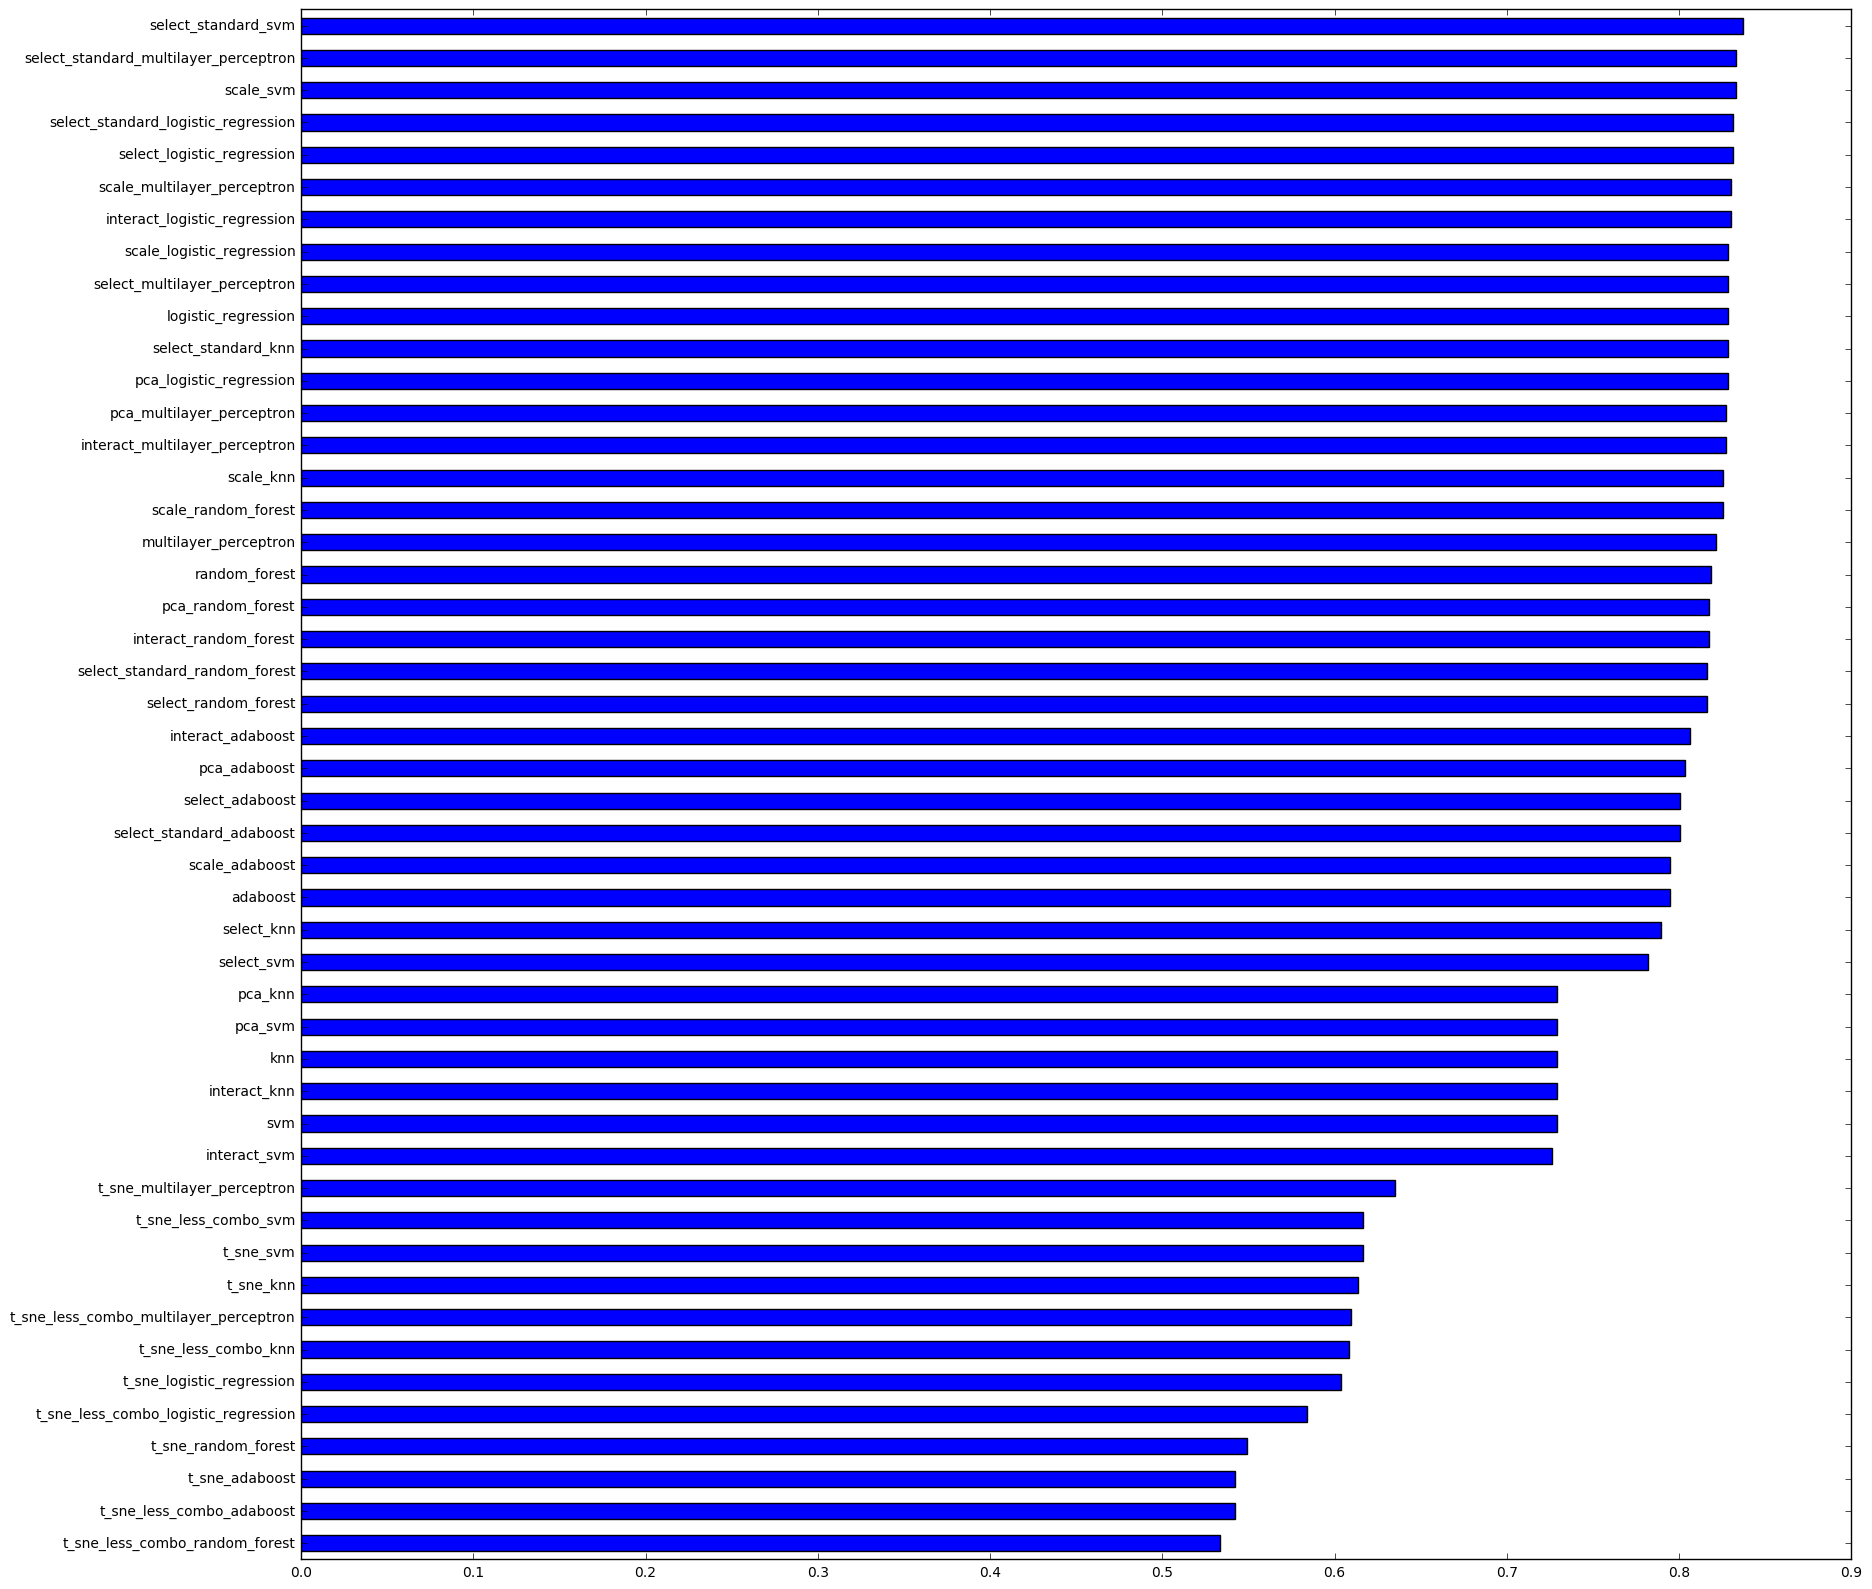

In [456]:
%matplotlib inline
score_df['training_score'].sort_values().plot(kind='barh',figsize=(20,20))

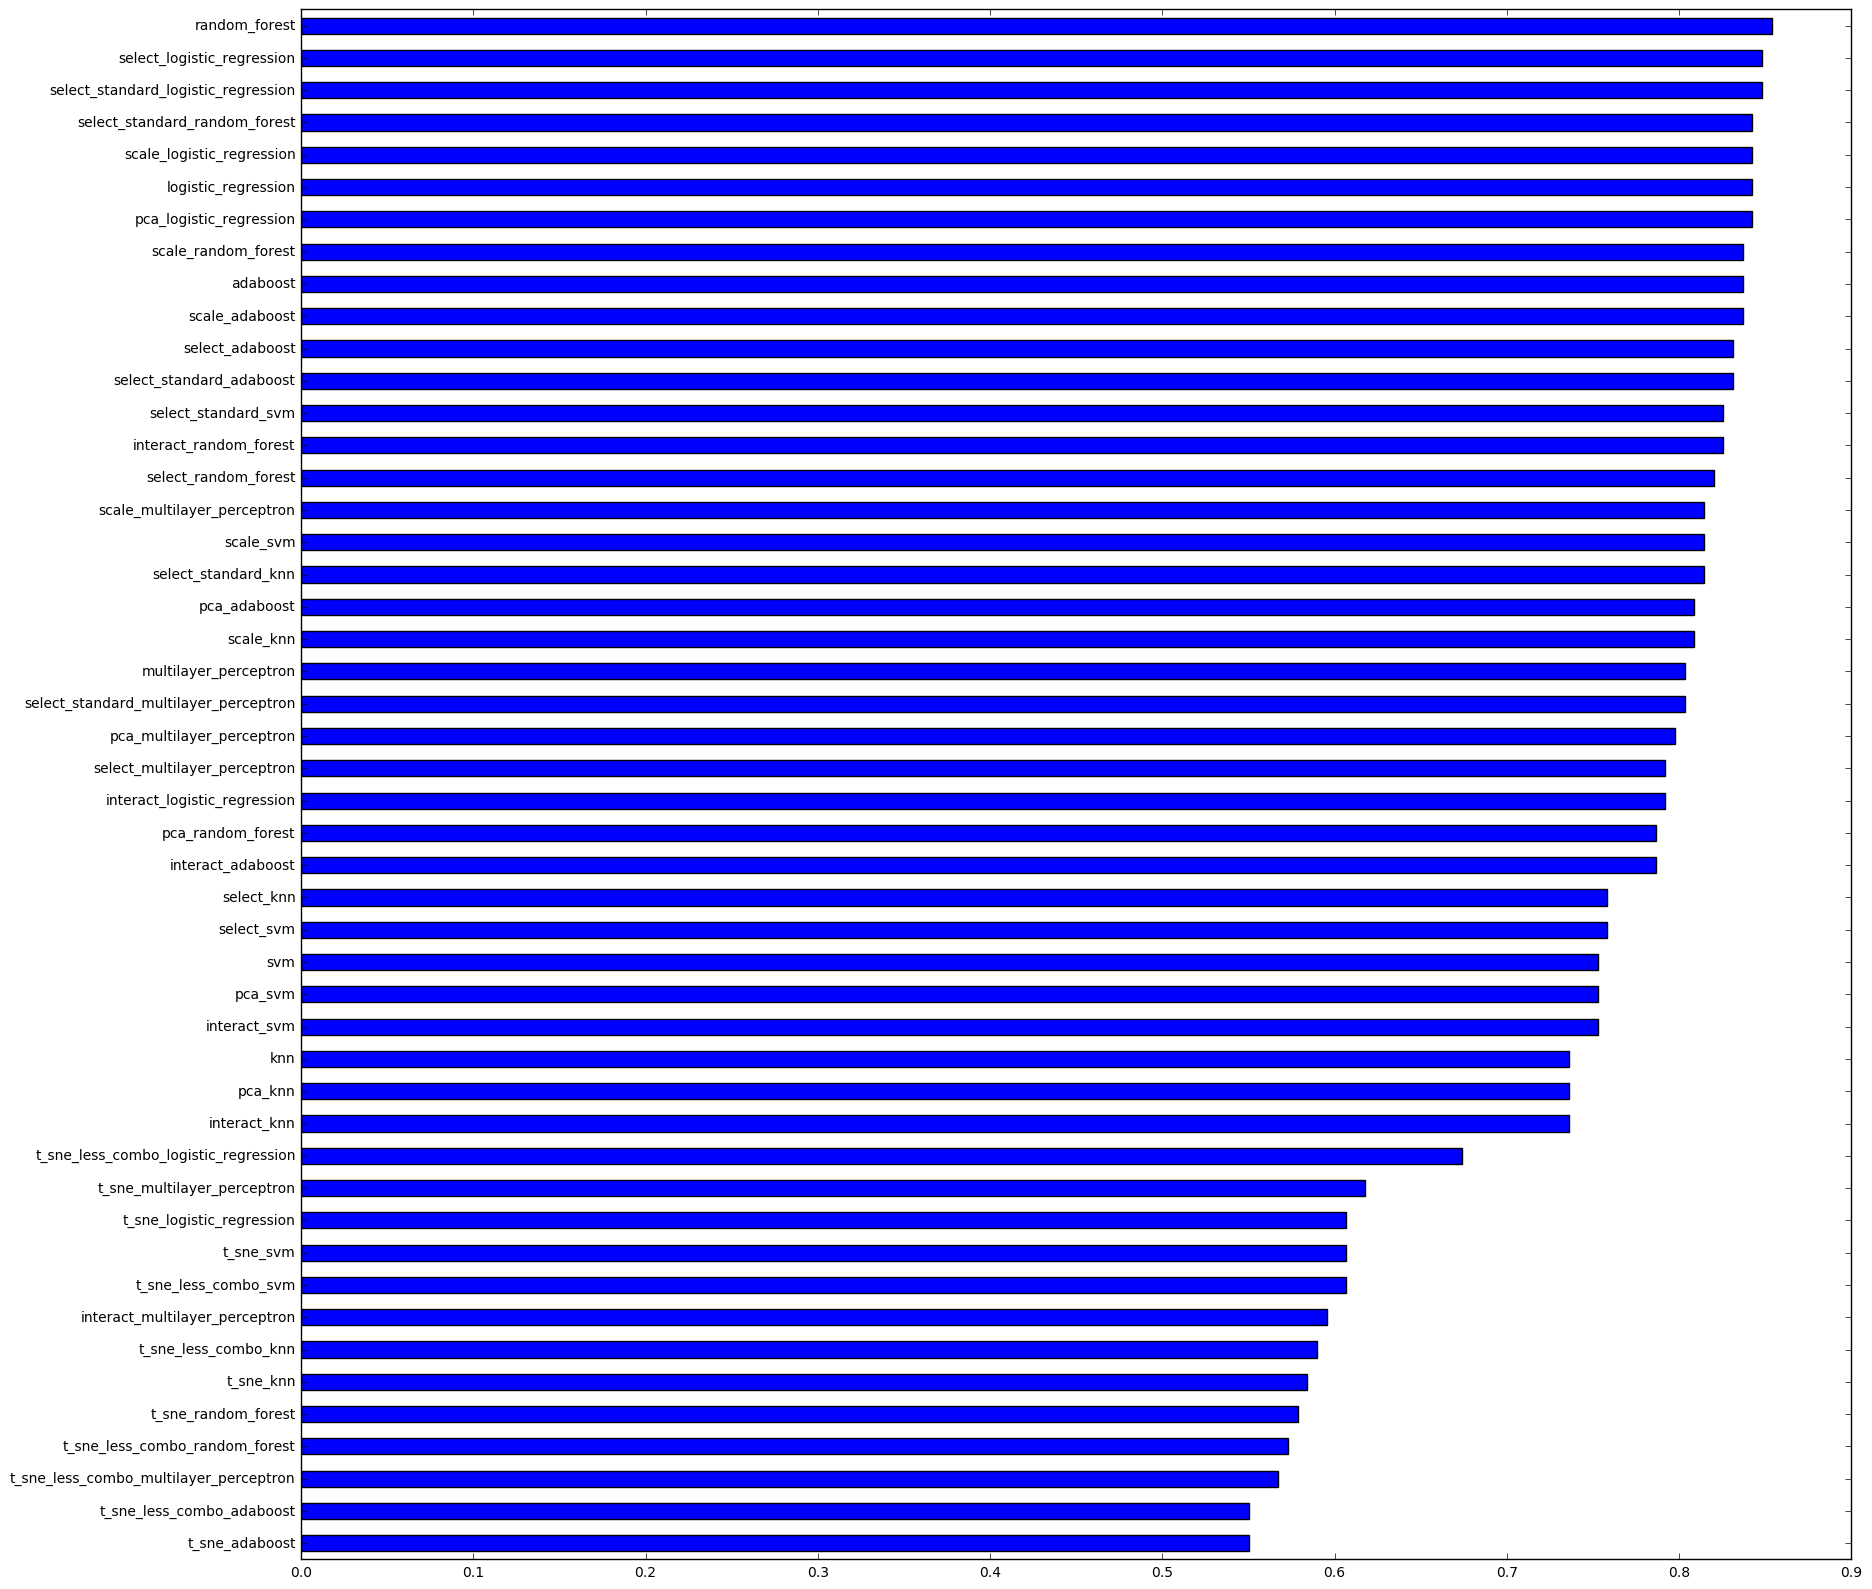

In [457]:
score_df['test_score'].sort_values().plot(kind='barh',figsize=(20,20))

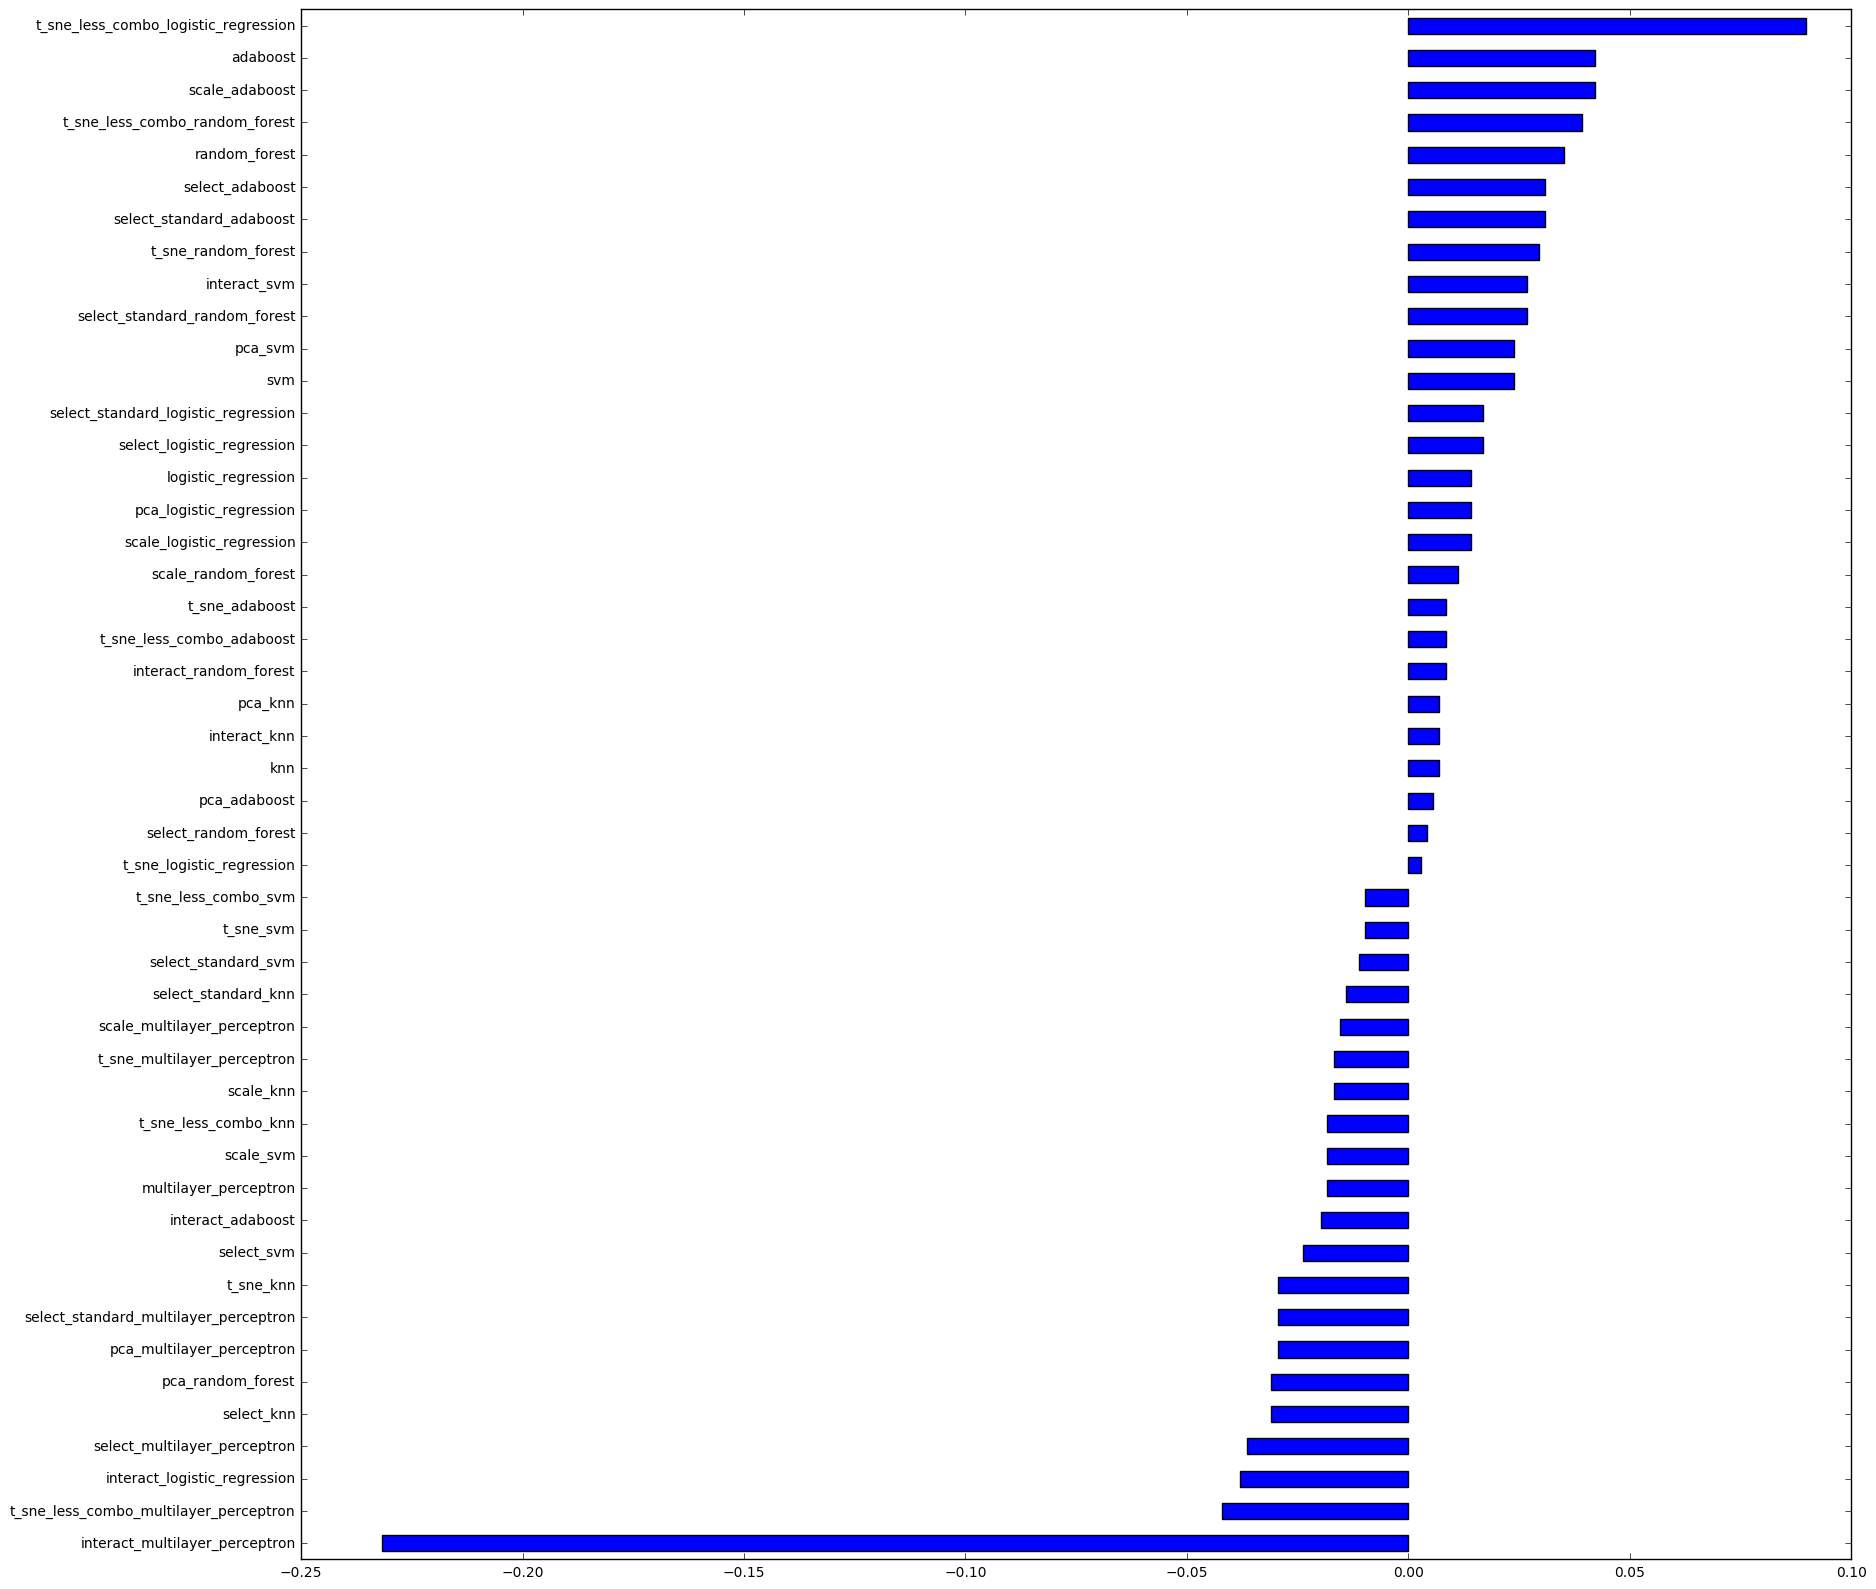

In [464]:
score_df['test-train'].sort_values().plot(kind='barh',figsize=(20,20))

In [470]:
(score_df['test_score']/score_df['test-train'].abs()).sort_values()

interact_multilayer_perceptron              2.569697
t_sne_less_combo_logistic_regression        7.500000
t_sne_less_combo_multilayer_perceptron     13.466667
t_sne_less_combo_random_forest             14.571429
t_sne_random_forest                        19.619048
t_sne_knn                                  19.809524
scale_adaboost                             19.866667
adaboost                                   19.866667
interact_logistic_regression               20.888889
select_multilayer_perceptron               21.692308
random_forest                              24.320000
select_knn                                 24.545455
pca_random_forest                          25.454545
select_standard_adaboost                   26.909091
select_adaboost                            26.909091
pca_multilayer_perceptron                  27.047619
select_standard_multilayer_perceptron      27.238095
interact_svm                               28.210526
svm                                        31.

In [463]:
len(optimized_pipelines)

48

So the best model was random forest.

Here's the report for the model:

In [462]:
print optimized_pipelines['random_forest']


Pipeline:

1: estimator   RandomForestClassifier           
                                              
               warm_start           = 0         
               oob_score            = 0         
               n_jobs               = 1         
               verbose              = 0         
               max_leaf_nodes       = None      
               bootstrap            = 1         
               min_samples_leaf     = 1         
               n_estimators         = 96        
               min_samples_split    = 2         
               min_weight_fraction_leaf = 0.0       
               criterion            = gini      
               random_state         = None      
               min_impurity_split   = 1e-07     
               max_features         = auto      
               max_depth            = None      
               class_weight         = None      
                                              

Training set classification accuracy:	0.819
Test set cla

In [440]:
len(optimized_pipelines.keys())

42

It turns out that the best model is logistic regression with a classfication accuracy of ~88%.

### Scaled data then classification
We can specify the scale_type keyword argument to scale the data before being fed to the desired estimator. Currently only standard scaling is supported:

In [ ]:
%%time 
reload(dsl)

# Set model names to iterate over
model_names = ['knn','logistic_regression','svm','multilayer_perceptron','random_forest','adaboost']        

# Cross-validate each model
for model_name in model_names:
    models['scaled_%s'%(model_name)] = dsl.train_model(X,y,
                                                       use_default_param_dist=True,
                                                       random_state=6,
                                                       scale_type = 'standard',
                                                       estimator=model_name)

In [ ]:
trained_model_names = models.keys()

model_scores = [models[model].test_score for model in trained_model_names]

max_score = max(model_scores)

best_model = trained_model_names[model_scores.index(max_score)]

print best_model,max_score, '\n\n',models[best_model].classification_report

### Feature selection, scaling, and classification
The feature_selection_type keyword argument can be used to select the best features:

In [ ]:
%%time 
reload(dsl)

# Set model names to iterate over
model_names = ['knn','logistic_regression','svm','multilayer_perceptron','random_forest','adaboost']        

# Cross-validate each model
for model_name in model_names:
    models['select_scaled_%s'%(model_name)] = dsl.train_model(X,y,
                                                       use_default_param_dist=True,
                                                       random_state=6,
                                                       scale_type = 'standard',
                                                       feature_selection_type = 'select_k_best', 
                                                       estimator=model_name)

In [ ]:
trained_model_names = models.keys()

model_scores = [models[model].test_score for model in trained_model_names]

max_score = max(model_scores)

best_model = trained_model_names[model_scores.index(max_score)]

print best_model,max_score, '\n\n',models[best_model].classification_report

It turns out that logistic regression without scaling outperforms all combinations of scalling and the classifiers.

### Scaled, transformed, then classification
Setting the transform_type keyword argument allows the data to be transformed into a new coordinate system that is dependent on the algorithm.

Currently, only principal component analysis (PCA) and t-distributed stochastic neighbor embedding (t-SNE) are supported.

#### PCA transformation

In [ ]:
%%time 
reload(dsl)

# Set model names to iterate over
model_names = ['knn','logistic_regression','svm','multilayer_perceptron','random_forest','adaboost']        

# Cross-validate each model
for model_name in model_names:
    models['scaled_pca_%s'%(model_name)] = dsl.train_model(X,y,use_default_param_dist=True,
                                                       random_state=6,
                                                        transform_type='pca',
                                                       scale_type = 'standard',
                                                       estimator=model_name)

In [ ]:
trained_model_names = models.keys()

model_scores = [models[model].test_score for model in trained_model_names]

max_score = max(model_scores)

best_model = trained_model_names[model_scores.index(max_score)]

print best_model,max_score,'\n\n',models[best_model].classification_report

Transformation with PCA doesn't appear to improve our results so far.

#### t-SNE

In [ ]:
%%time 
reload(dsl)

# Set model names to iterate over
model_names = ['knn','logistic_regression','svm','multilayer_perceptron','random_forest','adaboost']        

# Cross-validate each model
for model_name in model_names:
    models['scaled_t-sne_%s'%(model_name)] = dsl.train_model(X,y,use_default_param_dist=True,
                                                       random_state=6,
                                                        transform_type='t-sne',
                                                       scale_type = 'standard',
                                                       estimator=model_name)

In [ ]:
trained_model_names = models.keys()

model_scores = [models[model].test_score for model in trained_model_names]

max_score = max(model_scores)

best_model = trained_model_names[model_scores.index(max_score)]

print best_model,max_score,'\n\n',models[best_model].classification_report

Logistic regression with with scaling and selection appears to outperform all other scenarios so far.

Let's look at the best model's properties:

In [ ]:
print 'Best model:','logistic_regression','\n'
print 'Training score:\t\t', models['logistic_regression'].train_score
print 'Test score:\t\t', models['logistic_regression'].test_score,'\n'
print models['logistic_regression'].classification_report

print 'Confusion matrix:\n\n',models['logistic_regression'].confusion_matrix,'\n'
print 'Normalized confusion matrix:\n\n',models['logistic_regression'].normalized_confusion_matrix,'\n'
print 'Best parameters:\n', models['logistic_regression'].best_parameters